# EMD-ARIMA & ARIMA 모델을 적용한 SOH 예측

### 모듈 불러오기

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action = 'ignore')

import statsmodels.api as sm

In [4]:
from PyEMD import EMD,Visualisation, EEMD
from statsmodels.tsa.arima.model import ARIMA
from numpy.linalg import LinAlgError
from pandas import Series

### 데이터 불러오기

사용 데이터는 그룹A의 데이터 배터리 5,6,7,18 

In [5]:
bat_name = os.listdir('./data')

In [6]:
bat_name

['B05_discharge.csv',
 'B06_discharge.csv',
 'B07_discharge.csv',
 'B18_discharge.csv']

In [7]:
data = pd.read_csv('./data/%s'%bat_name[1],engine = 'python') # 5번 배터리 데이터

b005 = pd.read_csv('./data/%s'%bat_name[0],engine = 'python') # 5번 배터리 데이터
b006 = pd.read_csv('./data/%s'%bat_name[1],engine = 'python') # 6번 배터리 데이터
b007 = pd.read_csv('./data/%s'%bat_name[2],engine = 'python') # 7번 배터리 데이터
b018 = pd.read_csv('./data/%s'%bat_name[3],engine = 'python') # 18번 배터리 데이터

canonical_capacity = 2
soh_data = b005['capacity']/canonical_capacity
l = len(b005.columns)
b005.insert(l,'SOH',soh_data)

soh_data = b006['capacity']/canonical_capacity
l = len(b006.columns)
b006.insert(l,'SOH',soh_data)

soh_data = b007['capacity']/canonical_capacity
l = len(b007.columns)
b007.insert(l,'SOH',soh_data)

soh_data = b018['capacity']/canonical_capacity
l = len(b018.columns)
b018.insert(l,'SOH',soh_data)


<h5> 배터리 5 : b005<br><br>
     배터리 6 : b006<br><br>
     배터리 7 : b007<br><br>
     배터리 18 : b018
    
    

## SOH 계산 - column 추가

In [8]:
canonical_capacity = 2
soh_data = data['capacity']/canonical_capacity

l = len(data.columns)
data.insert(l,'SOH',soh_data)

In [9]:
pd.concat([data.head(),data.tail()],axis = 0)

,terminal_voltage,terminal_current,temperature,charge_current,charge_voltage,time,capacity,cycle,SOH
0,4.179800,-0.002366,24.277568,-0.0006,0.000,0.000,2.035338,1,1.017669
1,4.179823,0.000434,24.277073,-0.0006,4.195,16.781,2.035338,1,1.017669
2,3.966528,-2.014242,24.366226,-1.9990,3.070,35.703,2.035338,1,1.017669
3,3.945886,-2.008730,24.515123,-1.9990,3.045,53.781,2.035338,1,1.017669
4,3.930354,-2.013381,24.676053,-1.9990,3.026,71.922,2.035338,1,1.017669
50280,3.689577,-0.001671,32.367946,0.0006,0.000,2781.312,1.185675,168,0.592838
50281,3.690020,-0.001914,32.464485,0.0006,0.000,2791.062,1.185675,168,0.592838
50282,3.690708,-0.002706,32.337187,0.0006,0.000,2800.828,1.185675,168,0.592838
50283,3.691356,-0.002952,32.252598,0.0006,0.000,2810.640,1.185675,168,0.592838
50284,3.691809,-0.003127,32.192324,0.0006,0.000,2820.390,1.185675,168,0.592838


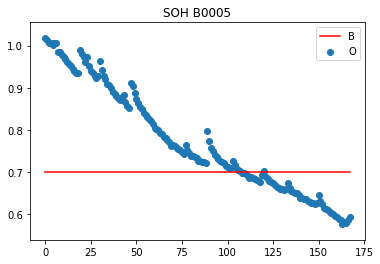

In [30]:
soh_list = data[data['time'] == 0]['SOH']

plt.scatter(range(168),soh_list)
plt.plot(range(168),[0.7 for i in range(168)],color = 'red')
plt.legend('%ssoh'%'BOOO5')
plt.title('SOH B0005')
plt.show()

## Threshold 0.7까지 남은 cycle수 (Remaining Useful Life)와 SOH 예측 목표

### Cycle 단위로 데이터의 분포 확인

In [24]:
times = []
for i in range(1,169):
    times.append(list(data[data['cycle']==i]['time'])[-1])

Text(0.5, 1.0, 'Times pf Cycles')

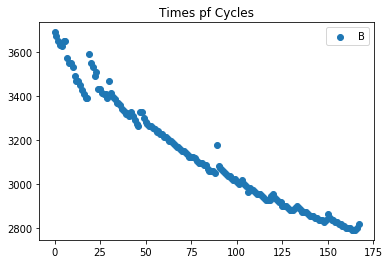

In [32]:
plt.scatter(range(168),times)
plt.legend('B0005 Times')
plt.title('Times pf Cycles')

SOH의 변화와 Cycle 관찰 시간의 패턴이 유사함을 보인다. 